In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne

import sys
sys.path.append('../src/utils')
from load_data import load_metadata, load_trial, load_all_data, load_subject_trials, load_by_session_and_trial, get_dataset_split # type: ignore

ImportError: cannot import name 'load_preprocessed_trial' from 'load_data' (c:\Users\iyadm\Documents\AIC3_Comp\eeg-signal-classification\notebooks\../src/utils\load_data.py)

In [2]:
metadata = load_metadata(base_path="../data/raw")
train_df = metadata['train']
test_df = metadata['test']
validation_df = metadata['validation']

In [3]:
train_df.describe(include='all')

,id,subject_id,task,trial_session,trial,label
count,4800.000000,4800,4800,4800.000000,4800.000000,4800
unique,NaN,30,2,NaN,NaN,4
top,NaN,S1,MI,NaN,NaN,Right
freq,NaN,160,2400,NaN,NaN,1812
mean,2400.500000,NaN,NaN,4.500000,5.500000,NaN
std,1385.784976,NaN,NaN,2.291527,2.872581,NaN
min,1.000000,NaN,NaN,1.000000,1.000000,NaN
25%,1200.750000,NaN,NaN,2.750000,3.000000,NaN
50%,2400.500000,NaN,NaN,4.500000,5.500000,NaN
75%,3600.250000,NaN,NaN,6.250000,8.000000,NaN


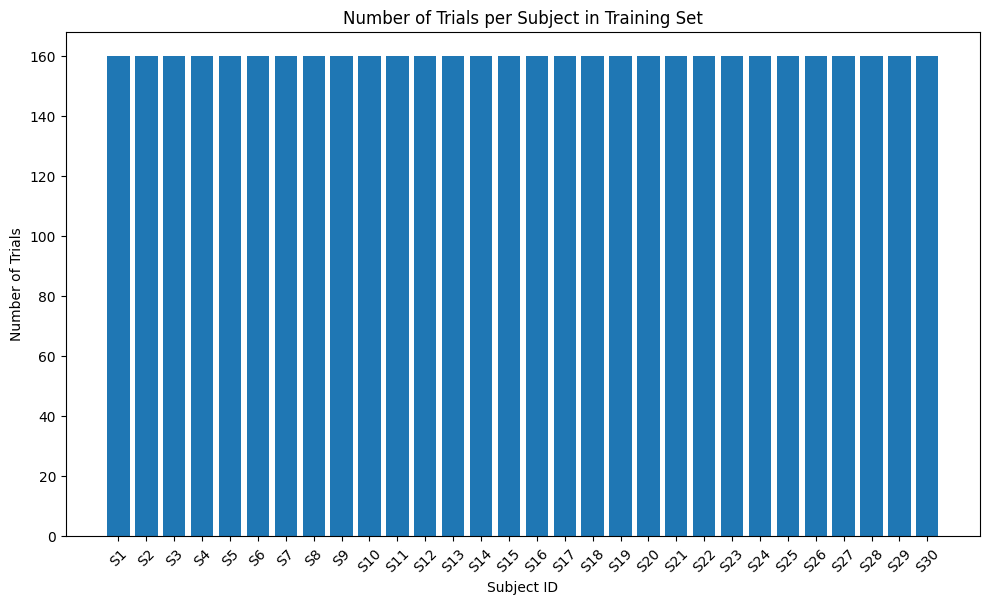

In [4]:
plt.figure(figsize=(10, 6))

subject_ids = ['S'+str(i) for i in range(1, 31)]
subject_counts = train_df['subject_id'].str.replace('S', '').astype(int).value_counts().sort_index()
plt.bar(subject_counts.index, subject_counts.values)
plt.xlabel('Subject ID')
plt.ylabel('Number of Trials')
plt.title('Number of Trials per Subject in Training Set')
plt.tight_layout()
plt.xticks(ticks=range(1, len(subject_ids)+1), labels=subject_ids, rotation=45)
plt.savefig('../outputs/plots/trials_per_subject.png')
plt.show()

In [35]:
def visualize_eeg_trial(data_dir, metadata_df, subject_id, session, trial_num, scale_factor=1e4, sfreq=250, duration=9):
    """
    Visualizes the EEG signals of a single trial using MNE.

    Parameters:
    - data_dir (str): Path to the raw EEG data directory.
    - metadata_df (pd.DataFrame): DataFrame containing trial metadata.
    - subject_id (str): Subject identifier (e.g., 'S20').
    - session (int): Session number (e.g., 1).
    - trial_num (int): Trial number to visualize (e.g., 1).
    - scale_factor (float): Factor to divide EEG readings by (default: 1e4 to convert to Volts).
    - sfreq (int): Sampling frequency in Hz (default: 250).
    - duration (int): Duration of the plot in seconds (default: 9).
    """
    # Load the trial data
    df_trial = load_by_session_and_trial(data_dir, metadata_df, subject_id, session, trial_num)
    
    # Extract EEG channel names and values
    channel_names = df_trial.columns[1:9].tolist()
    eeg_data = df_trial[channel_names].values / scale_factor  # Scale if necessary

    # Create MNE info and Raw object
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types=['eeg'] * len(channel_names))
    raw = mne.io.RawArray(eeg_data.T, info)
    
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)
    
    label = metadata_df[
        (metadata_df['subject_id'] == subject_id) &
        (metadata_df['trial_session'] == session) &
        (metadata_df['trial'] == trial_num)
    ]['label'].values[0]

    # Plot the raw EEG data
    raw.plot(
        duration=duration,
        n_channels=len(channel_names),
        scalings='auto',
        title=f'{subject_id} - Session {session}, Trial {trial_num} EEG',
        show=True,
        show_options=True
    )
    print(f"Visualized {subject_id} - Session {session}, Trial {trial_num} EEG data. Label: {label}")

In [36]:
visualize_eeg_trial(
    data_dir='../data/raw',
    metadata_df=train_df,
    subject_id='S1',
    session=1,
    trial_num=5,
    scale_factor=1e4,
)

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


ValueError: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The channels missing from the montage are:

['FZ', 'CZ', 'PZ', 'OZ'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.


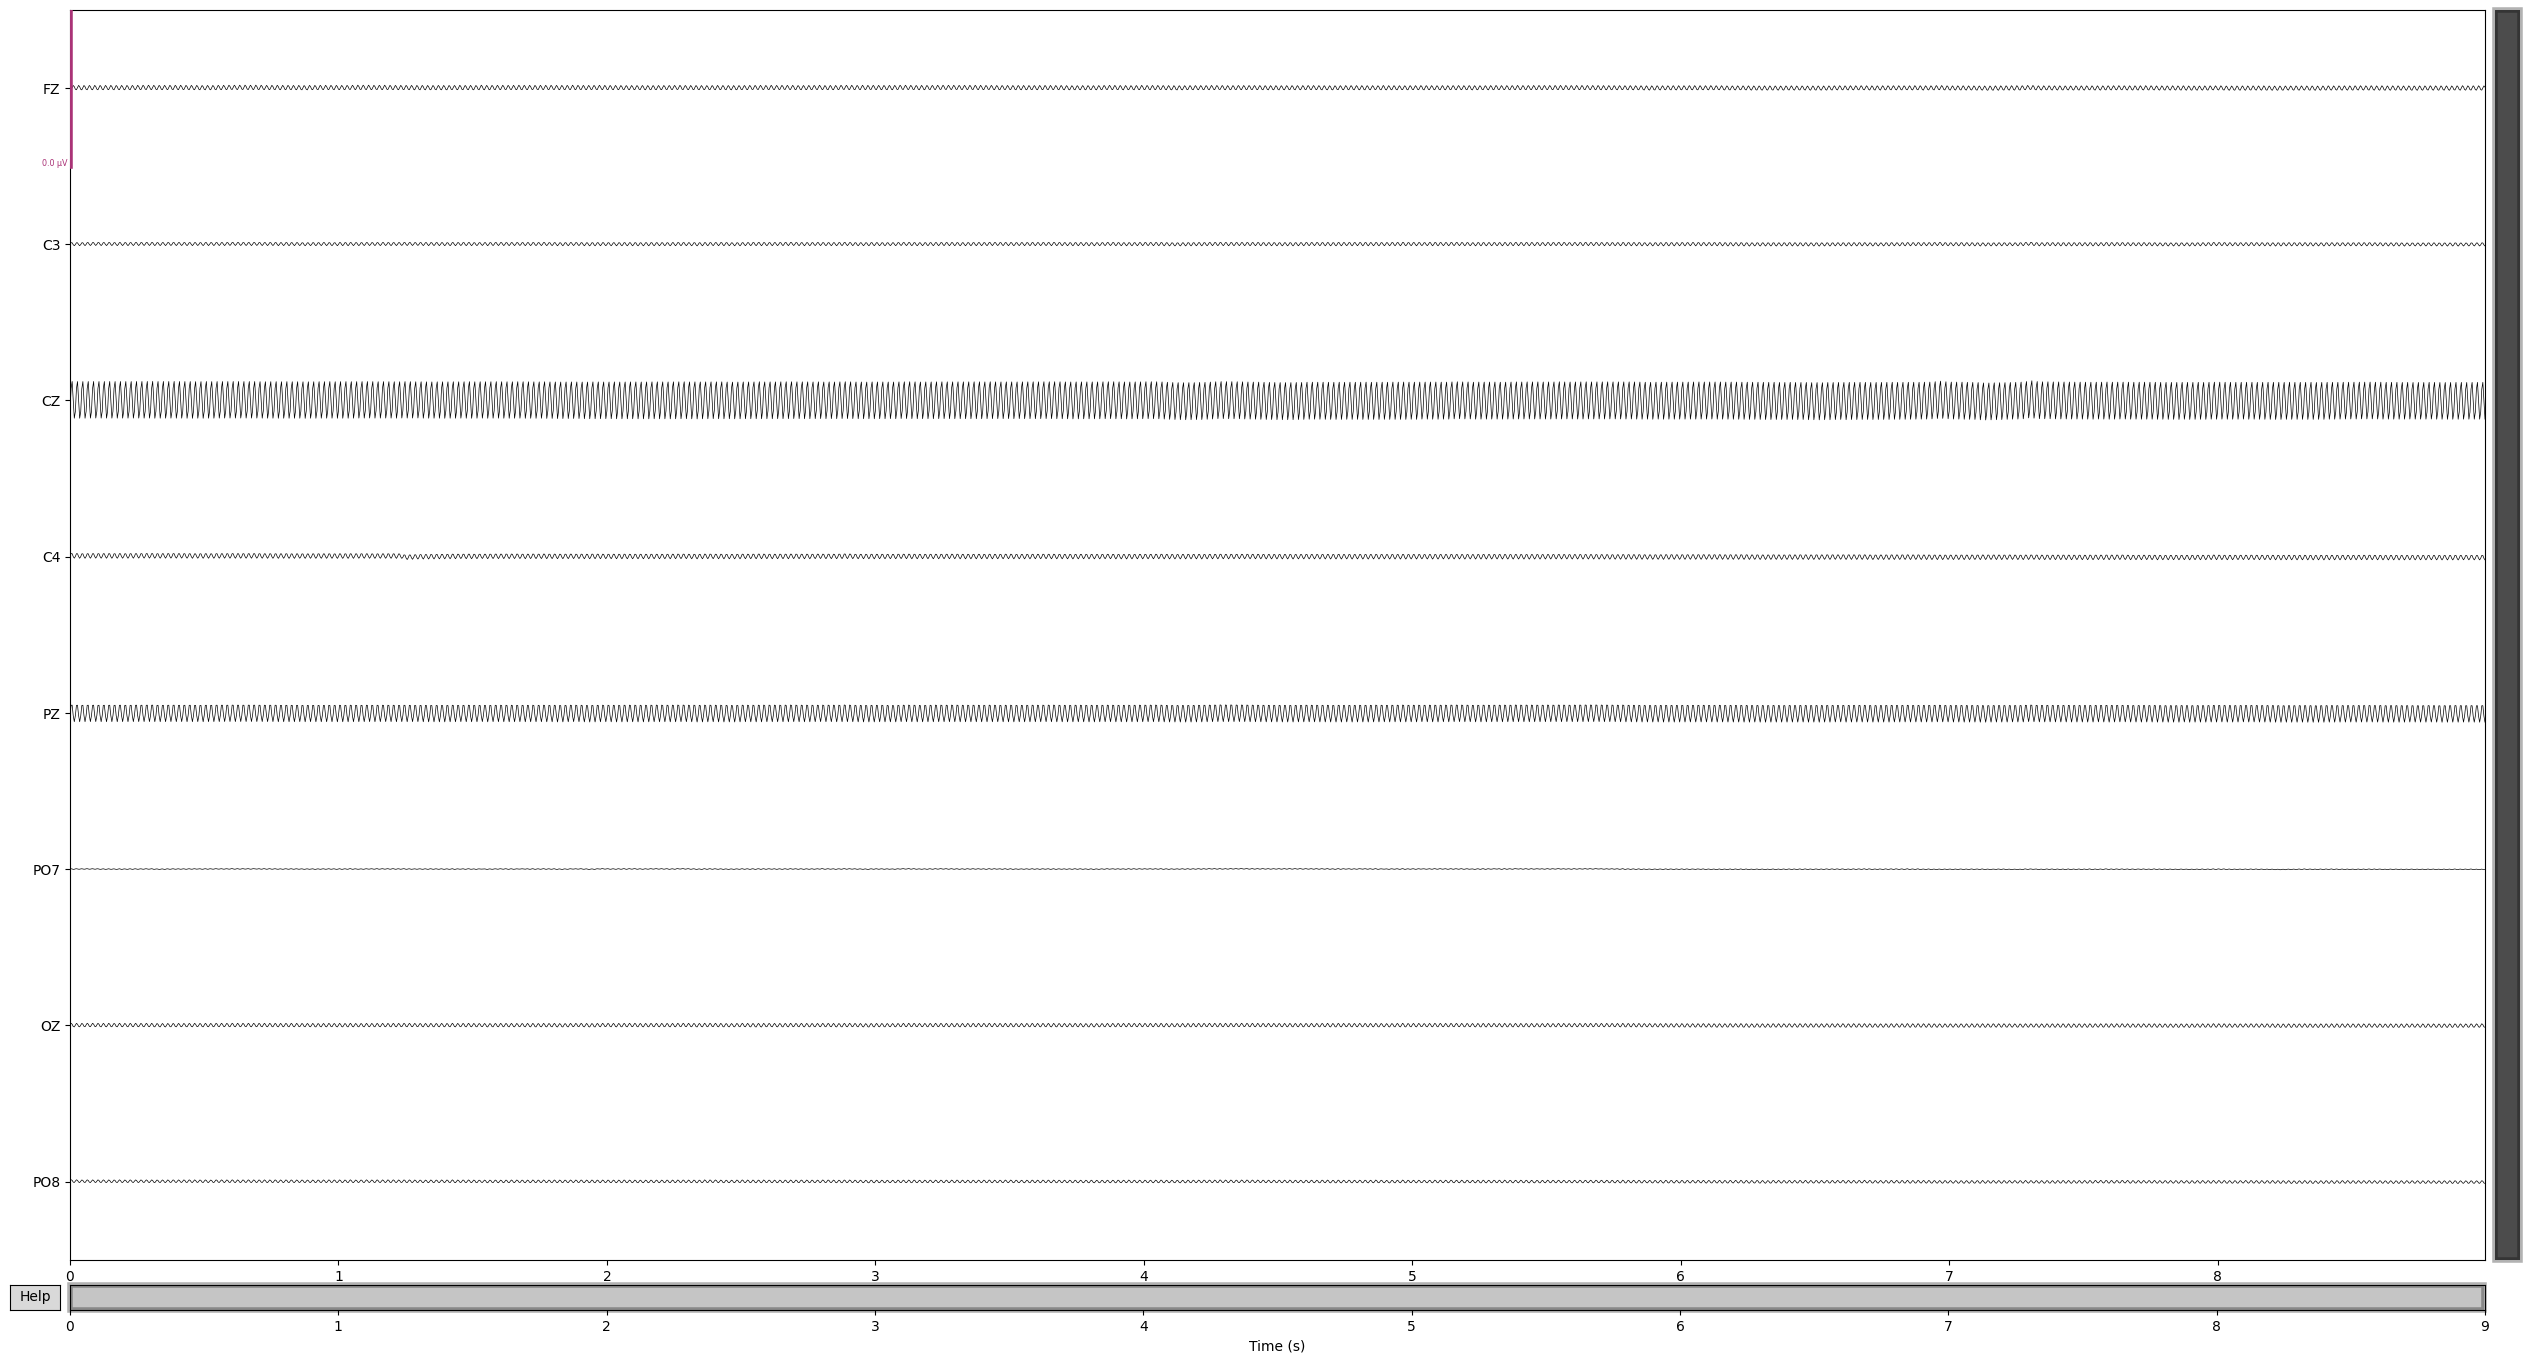

Visualized S1 - Session 1, Trial 3 EEG data. Label: Left


In [30]:
visualize_eeg_trial(
    data_dir='../data/raw',
    metadata_df=train_df,
    subject_id='S1',
    session=1,
    trial_num=3,
    scale_factor=1e4,
)

In [39]:
def visualize_eeg_trial_psd(data_dir, metadata_df, subject_id, session, trial_num, scale_factor=1e4, sfreq=250, fmin=0, fmax=60):
    """
    Visualizes the Power Spectral Density (PSD) of EEG signals from a single trial using MNE.

    Parameters:
    - data_dir (str): Path to the raw EEG data directory.
    - metadata_df (pd.DataFrame): DataFrame containing trial metadata.
    - subject_id (str): Subject identifier (e.g., 'S20').
    - session (int): Session number (e.g., 1).
    - trial_num (int): Trial number to visualize (e.g., 1).
    - scale_factor (float): Factor to divide EEG readings by (default: 1e4 to convert to Volts).
    - sfreq (int): Sampling frequency in Hz (default: 250).
    - fmin (float): Minimum frequency to display (default: 0 Hz).
    - fmax (float): Maximum frequency to display (default: 60 Hz).
    """
    # Load the trial data
    df_trial = load_by_session_and_trial(data_dir, metadata_df, subject_id, session, trial_num)

    # Extract EEG channel names and values
    channel_names = df_trial.columns[1:9].tolist()
    eeg_data = df_trial[channel_names].values / scale_factor

    # Create MNE info and Raw object
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types=['eeg'] * len(channel_names))
    raw = mne.io.RawArray(eeg_data.T, info)
    
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage, on_missing='warn')  # warn if any are still missing

    label = metadata_df[
        (metadata_df['subject_id'] == subject_id) &
        (metadata_df['trial_session'] == session) &
        (metadata_df['trial'] == trial_num)
    ]['label'].values[0]

    # Plot the PSD
    raw.plot_psd(fmin=fmin, fmax=fmax, average=False, spatial_colors=True, dB=True)
    print(f"Plotted PSD for {subject_id} - Session {session}, Trial {trial_num}. Label: {label}")

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\iyadm\AppData\Local\Temp\ipykernel_1556\1556337484.py:28: RuntimeWarning: DigMontage is only a subset of info. There are 4 channel positions not present in the DigMontage. The channels missing from the montage are:

['FZ', 'CZ', 'PZ', 'OZ'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')  # warn if any are still missing
c:\Users\iyadm\Documents\AIC3_Comp\eeg-signal-classification\venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Plotted PSD for S20 - Session 1, Trial 3. Label: Left


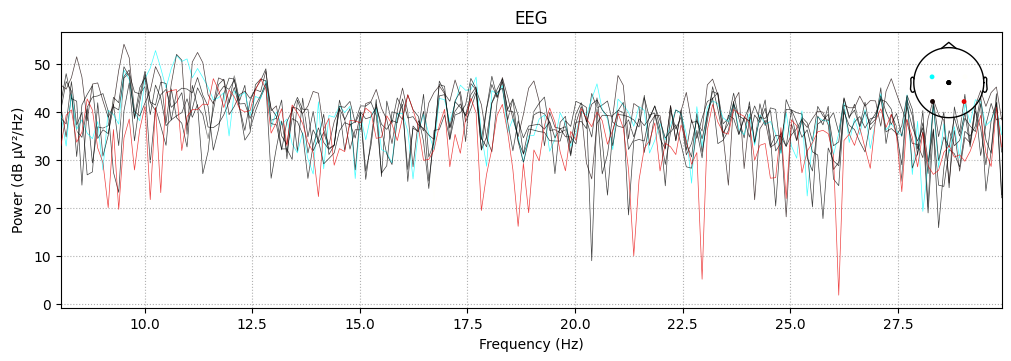

In [40]:
visualize_eeg_trial_psd(
    data_dir='../data/raw',
    metadata_df=train_df,
    subject_id='S20',
    session=1,
    trial_num=3,
    scale_factor=1e4,
    fmin=8,
    fmax=30
)

In [ ]:

def plot_eeg_channels(
    data_dir,
    metadata_df,
    subject_id,
    session,
    trial_num,
    scale_factor=1e4,
    figsize=(12, 8)
):
    """
    Plots EEG signals for all channels using matplotlib.

    Parameters:
    - data_dir (str): Path to raw EEG data.
    - metadata_df (pd.DataFrame): DataFrame with metadata.
    - subject_id (str): e.g., 'S20'
    - task (str): Task type, e.g., 'MI' or 'SSVEP'
    - session (int): Session number.
    - trial_num (int): Trial number.
    - scale_factor (float): Factor to divide signal values (e.g., 1e4 to convert to volts).
    - figsize (tuple): Size of the matplotlib figure.
    """
    # Load EEG data
    df = load_by_session_and_trial(data_dir, metadata_df, subject_id, session, trial_num)
    label = metadata_df[
        (metadata_df['subject_id'] == subject_id) &
        (metadata_df['trial_session'] == session) &
        (metadata_df['trial'] == trial_num)
    ]['label'].values[0]
    
    # Extract channel names and EEG data
    channel_names = df.columns[1:9].tolist()  # assuming EEG channels are columns 1 to 8
    eeg_data = df[channel_names].values / scale_factor

    # Plotting
    time = range(eeg_data.shape[0])
    fig, axs = plt.subplots(len(channel_names), 1, figsize=figsize, sharex=True)
    fig.suptitle(f'{subject_id} - Session {session} - Trial {trial_num} - Label: {label}', fontsize=14)

    for i, ax in enumerate(axs):
        ax.plot(time, eeg_data[:, i], color='black', linewidth=0.8)
        ax.set_ylabel(channel_names[i])
        ax.grid(True)
        if i == len(channel_names) - 1:
            ax.set_xlabel('Time (samples)')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # reserve space for suptitle
    plt.show()

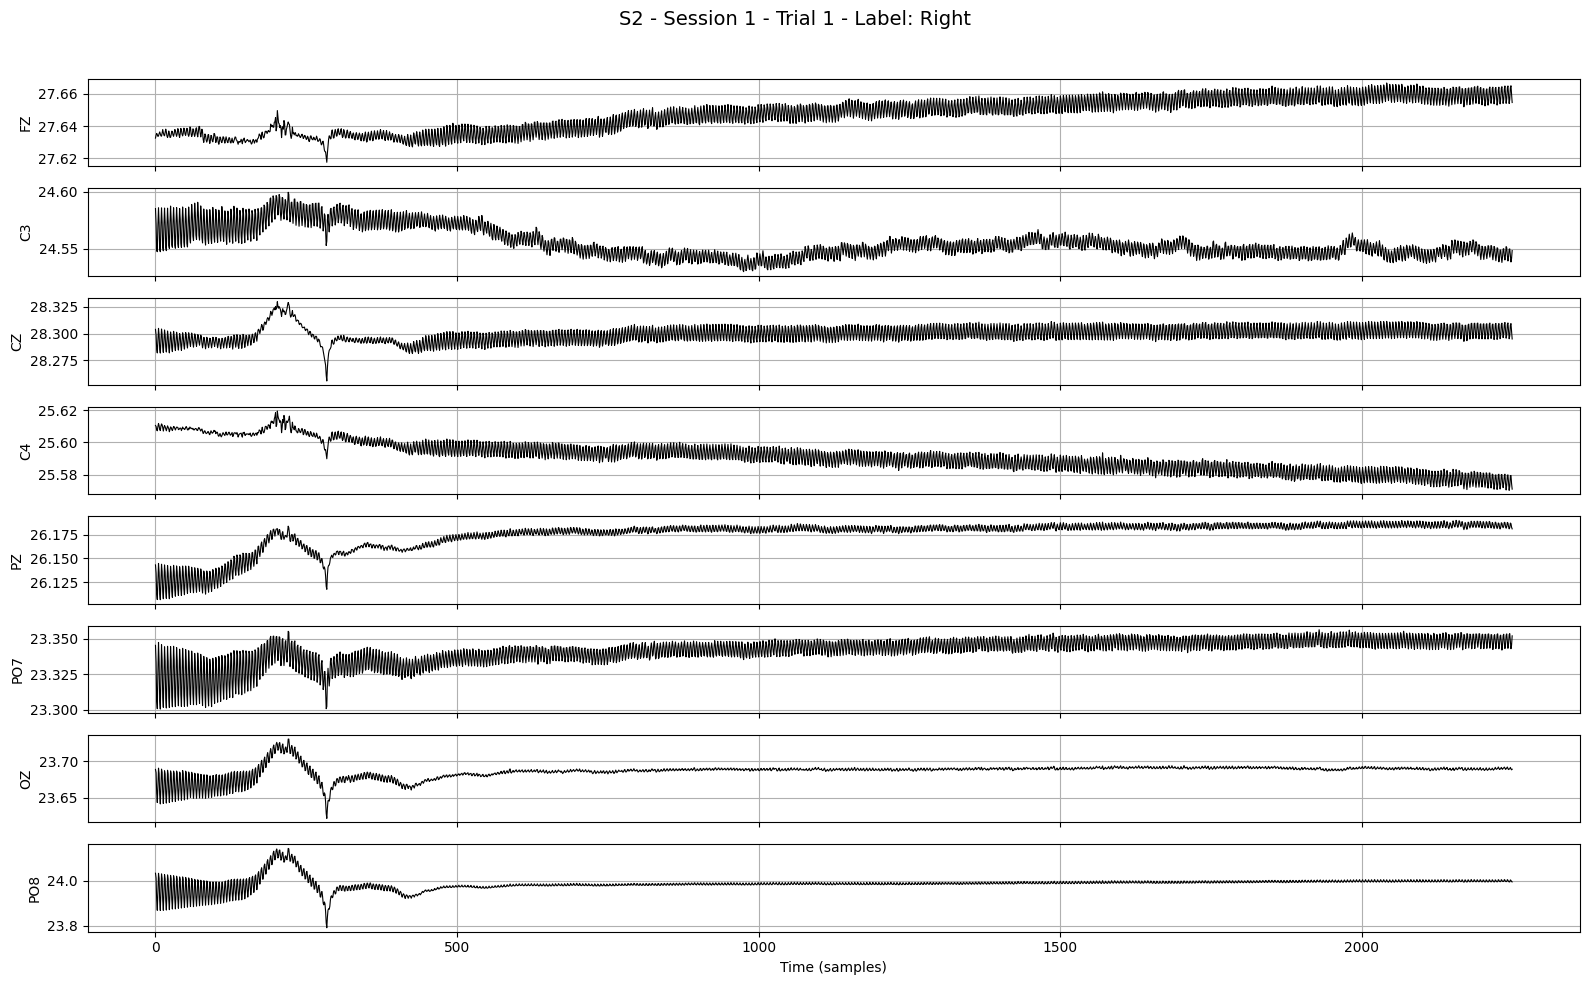

In [53]:
plot_eeg_channels(
    data_dir='../data/raw',
    metadata_df=train_df,
    subject_id='S2',
    session=1,
    trial_num=1,
    figsize=(16, 10)
)

In [54]:
def plot_eeg_channels_with_sensors(
    data_dir,
    metadata_df,
    subject_id,
    session,
    trial_num,
    scale_factor=1e4,
    figsize=(15, 16)
):
    """
    Plots EEG, accelerometer, gyroscope, battery, and validation flag signals.

    Parameters:
    - data_dir (str): Path to raw EEG data.
    - metadata_df (pd.DataFrame): DataFrame with metadata.
    - subject_id (str): e.g., 'S20'
    - session (int): Session number.
    - trial_num (int): Trial number.
    - scale_factor (float): Factor to divide signal values (e.g., 1e4 to convert to volts).
    - figsize (tuple): Size of the matplotlib figure.
    """
    # Load trial data
    df = load_by_session_and_trial(data_dir, metadata_df, subject_id, session, trial_num)
    
    # Extract label
    label = metadata_df[
        (metadata_df['subject_id'] == subject_id) &
        (metadata_df['trial_session'] == session) &
        (metadata_df['trial'] == trial_num)
    ]['label'].values[0]

    # EEG channels
    eeg_channels = df.columns[1:9].tolist()
    eeg_data = df[eeg_channels].values / scale_factor

    # Sensor channels
    acc_channels = ['AccX', 'AccY', 'AccZ']
    gyro_channels = ['Gyro1', 'Gyro2', 'Gyro3']
    battery_col = 'Battery'
    validation_col = 'Validation'

    # Time
    time = range(df.shape[0])
    
    # Total subplots: EEG + 3 sensor plots + battery + validation
    total_plots = len(eeg_channels) + 4

    fig, axs = plt.subplots(total_plots, 1, figsize=figsize, sharex=True)
    fig.suptitle(f'{subject_id} - Session {session} - Trial {trial_num} - Label: {label}', fontsize=16)

    # Plot EEG
    for i, ch in enumerate(eeg_channels):
        axs[i].plot(time, eeg_data[:, i], color='black', linewidth=0.8)
        axs[i].set_ylabel(ch)
        axs[i].grid(True)

    # Plot accelerometer
    i += 1
    for acc in acc_channels:
        axs[i].plot(time, df[acc], label=acc)
    axs[i].set_ylabel('Accelerometer')
    axs[i].legend()
    axs[i].grid(True)

    # Plot gyroscope
    i += 1
    for gyro in gyro_channels:
        axs[i].plot(time, df[gyro], label=gyro)
    axs[i].set_ylabel('Gyroscope')
    axs[i].legend()
    axs[i].grid(True)

    # Plot battery
    i += 1
    axs[i].plot(time, df[battery_col], color='green')
    axs[i].set_ylabel('Battery')
    axs[i].grid(True)

    # Plot validation flag
    i += 1
    axs[i].plot(time, df[validation_col], color='red')
    axs[i].set_ylabel('Validation')
    axs[i].set_xlabel('Time (samples)')
    axs[i].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

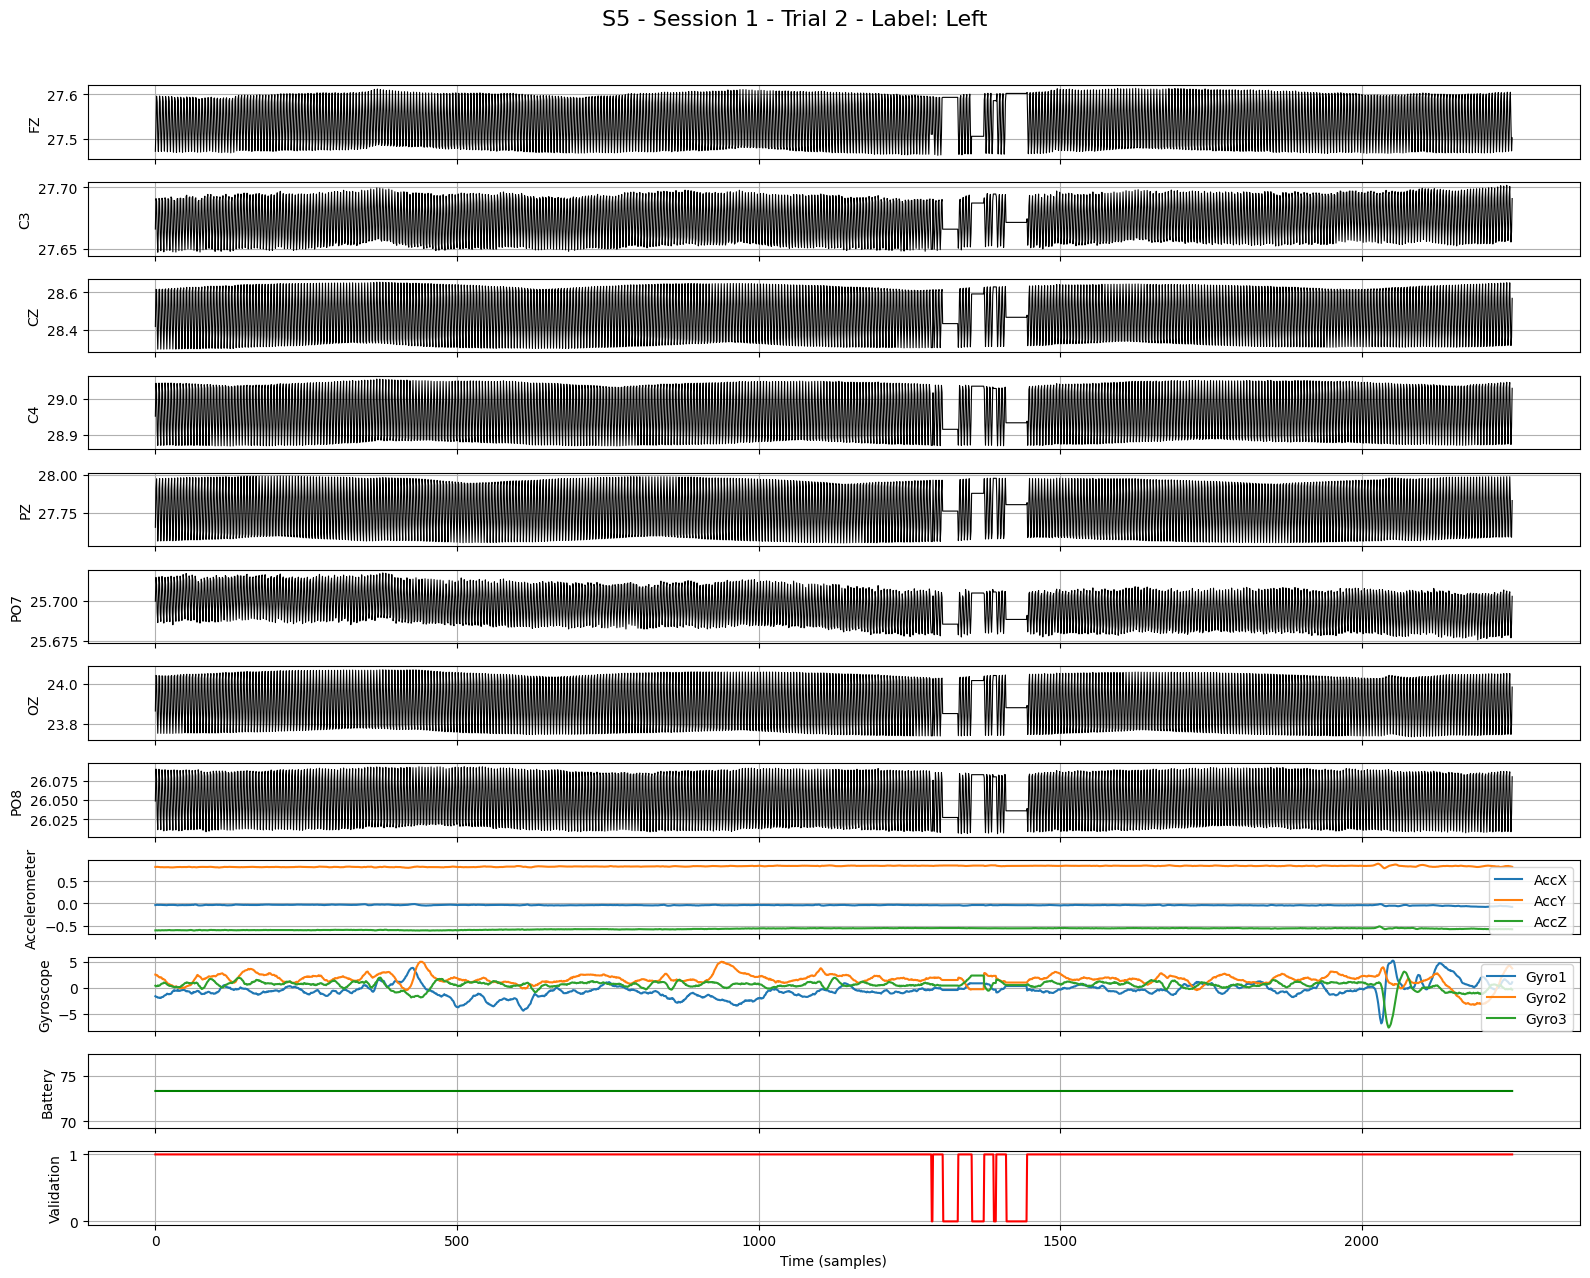

In [61]:
plot_eeg_channels_with_sensors(
    data_dir='../data/raw',
    metadata_df=train_df,
    subject_id='S5',
    session=1,
    trial_num=2,
    figsize=(16, 13)
)

In [69]:
import matplotlib.pyplot as plt
import numpy as np
            
def plot_eeg_channels_with_magnitude(
    data_dir,
    metadata_df,
    subject_id,
    session,
    trial_num,
    scale_factor=1e4,
    figsize=(15, 14),
    acc_thresh=15,
    gyro_thresh=5,
    battery_thresh=0.9
):
    """
    Plots EEG channels + accelerometer and gyroscope magnitude + battery and validation flag.
    Annotates bad samples in red.

    Parameters:
    - data_dir (str): Path to raw EEG data.
    - metadata_df (pd.DataFrame): DataFrame with metadata.
    - subject_id (str): e.g., 'S20'
    - session (int): Session number.
    - trial_num (int): Trial number.
    - scale_factor (float): Factor to divide EEG signal values.
    - figsize (tuple): Size of the figure.
    - acc_thresh (float): Threshold for accelerometer magnitude to flag bad samples.
    - gyro_thresh (float): Threshold for gyroscope magnitude to flag bad samples.
    - battery_thresh (float): Threshold for battery level to flag bad samples.
    """
    # Load data
    df = load_by_session_and_trial(data_dir, metadata_df, subject_id, session, trial_num)

    # Extract label
    label = metadata_df[
        (metadata_df['subject_id'] == subject_id) &
        (metadata_df['trial_session'] == session) &
        (metadata_df['trial'] == trial_num)
    ]['label'].values[0]

    # EEG
    eeg_channels = df.columns[1:9].tolist()
    eeg_data = df[eeg_channels].values / scale_factor

    # Motion
    acc = df[['AccX', 'AccY', 'AccZ']].values
    gyro = df[['Gyro1', 'Gyro2', 'Gyro3']].values
    acc_magnitude = np.linalg.norm(acc, axis=1)
    gyro_magnitude = np.linalg.norm(gyro, axis=1)

    # Other sensors
    battery = df['Battery'].values
    validation = df['Validation'].values
    counter = df['Counter'].values

    # Detect counter jumps
    counter_diff = np.diff(counter, prepend=counter[0])
    counter_jump = counter_diff > 1

    # Bad sample mask
    bad_samples = (
        (acc_magnitude > acc_thresh) |
        (gyro_magnitude > gyro_thresh) |
        (battery < battery_thresh) |
        (validation == 0) |
        (counter_jump)
    )

    # Time
    time = np.arange(df.shape[0])

    # Plotting
    total_plots = len(eeg_channels) + 4
    fig, axs = plt.subplots(total_plots, 1, figsize=figsize, sharex=True)
    fig.suptitle(f'{subject_id} - Session {session} - Trial {trial_num} - Label: {label}', fontsize=16)

    # EEG plots
    for i, ch in enumerate(eeg_channels):
        axs[i].plot(time, eeg_data[:, i], color='black', linewidth=0.8)
        axs[i].set_ylabel(ch)
        axs[i].grid(True)
        annotate_bad_regions(axs[i], bad_samples)

    # Acc magnitude
    axs[i+1].plot(time, acc_magnitude, color='blue')
    axs[i+1].set_ylabel('Acc Magnitude')
    axs[i+1].grid(True)
    annotate_bad_regions(axs[i+1], bad_samples)

    # Gyro magnitude
    axs[i+2].plot(time, gyro_magnitude, color='purple')
    axs[i+2].set_ylabel('Gyro Magnitude')
    axs[i+2].grid(True)
    annotate_bad_regions(axs[i+2], bad_samples)

    # Battery
    axs[i+3].plot(time, battery, color='green')
    axs[i+3].set_ylabel('Battery')
    axs[i+3].grid(True)
    annotate_bad_regions(axs[i+3], bad_samples)

    # Validation
    axs[i+4].plot(time, validation, color='red')
    axs[i+4].set_ylabel('Validation')
    axs[i+4].set_xlabel('Time (samples)')
    axs[i+4].grid(True)
    annotate_bad_regions(axs[i+4], bad_samples)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
def annotate_bad_regions(ax, bad_mask, color='red', alpha=0.15):
        in_bad = False
        start = 0
        for i, is_bad in enumerate(bad_mask):
            if is_bad and not in_bad:
                start = i
                in_bad = True
            elif not is_bad and in_bad:
                ax.axvspan(start, i, color=color, alpha=alpha)
                in_bad = False
        if in_bad:
            ax.axvspan(start, len(bad_mask), color=color, alpha=alpha)

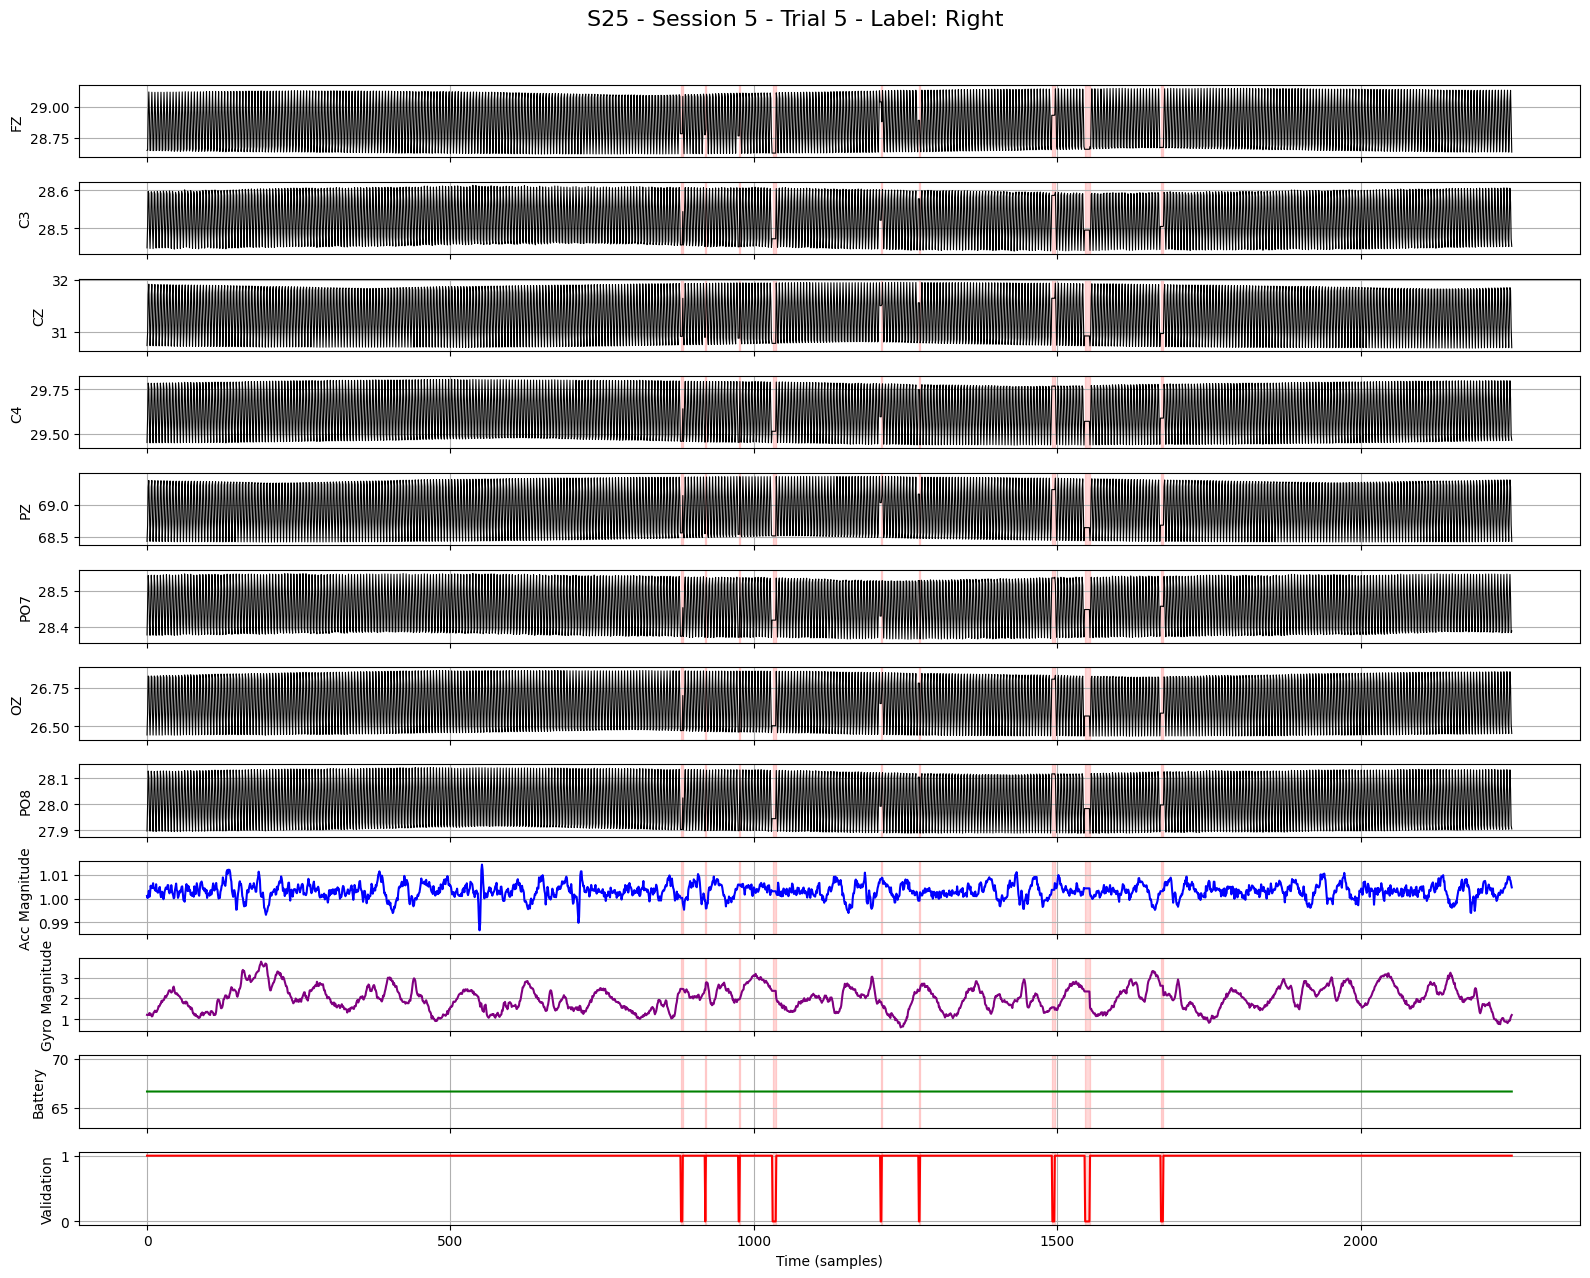

In [76]:
plot_eeg_channels_with_magnitude(
    data_dir='../data/raw',
    metadata_df=train_df,
    subject_id='S25',
    session=5,
    trial_num=5,
    figsize=(16, 13)
)

In [ ]:
def get_bad_mask(df, acc_thresh=15, gyro_thresh=5, battery_thresh=0.9):
    acc = df[['AccX', 'AccY', 'AccZ']].values
    gyro = df[['Gyro1', 'Gyro2', 'Gyro3']].values
    acc_mag = np.linalg.norm(acc, axis=1)
    gyro_mag = np.linalg.norm(gyro, axis=1)
    counter_jump = np.diff(df['Counter'], prepend=df['Counter'].iloc[0]) > 1

    return (
        (acc_mag > acc_thresh) |
        (gyro_mag > gyro_thresh) |
        (df['Battery'].values < battery_thresh) |
        (df['Validation'].values == 0) |
        counter_jump
    )

def remove_bad_segments(df, bad_mask, threshold=0.3):
    """
    Removes bad samples or the entire DataFrame based on a threshold.

    Parameters:
    - df (pd.DataFrame): EEG + sensor data.
    - bad_mask (np.ndarray): Boolean array marking bad samples.
    - threshold (float): If bad proportion > threshold, discard all data.

    Returns:
    - pd.DataFrame or None
    """
    bad_ratio = bad_mask.sum() / len(bad_mask)
    if bad_ratio > threshold:
        return None  # Drop entire segment
    else:
        return df[~bad_mask].reset_index(drop=True)
    
def interpolate_bad_segments(df, bad_mask, threshold=0.3, method='linear'):
    """
    Interpolates bad samples, or discards all data if bad ratio exceeds threshold.

    Parameters:
    - df (pd.DataFrame): EEG + sensor data.
    - bad_mask (np.ndarray): Boolean array marking bad samples.
    - threshold (float): If bad proportion > threshold, discard all data.
    - method (str): Interpolation method (e.g., 'linear', 'spline', etc.)

    Returns:
    - pd.DataFrame or None
    """
    bad_ratio = bad_mask.sum() / len(bad_mask)
    if bad_ratio > threshold:
        return None  # Discard
    else:
        df_clean = df.copy()
        df_clean[bad_mask] = np.nan
        df_clean = df_clean.interpolate(method=method, limit_direction='both', axis=0)
        return df_clean

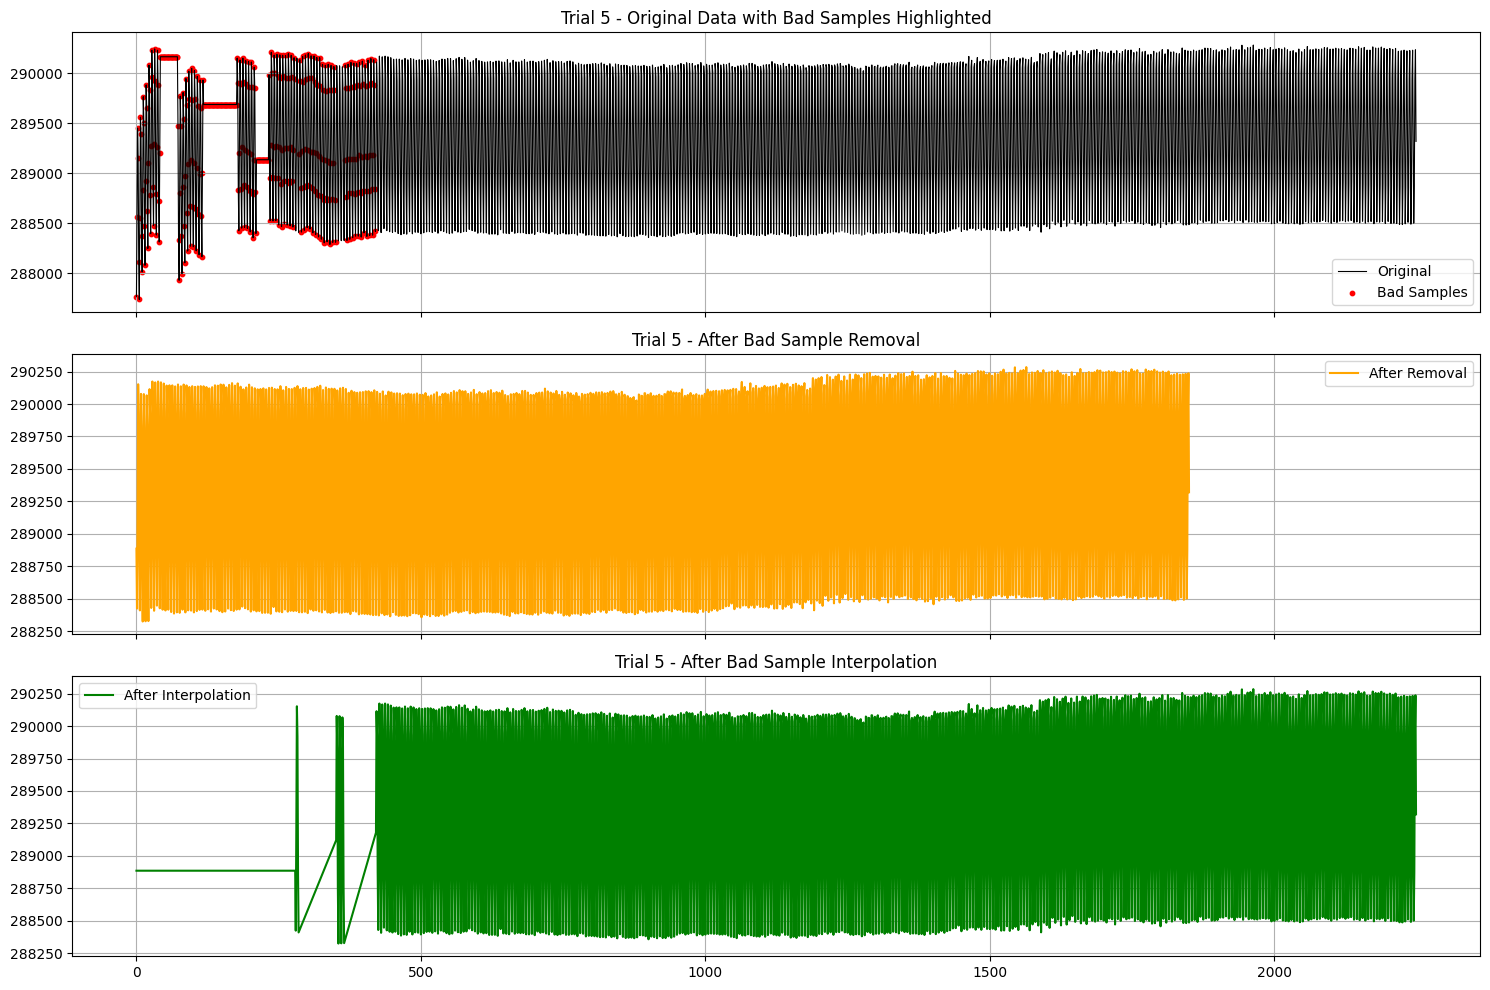

In [ ]:
df = load_by_session_and_trial('../data/raw', train_df, 'S5', 2, 1)  # your existing function
bad_mask = get_bad_mask(df)
removed_df = remove_bad_segments(df, bad_mask)
interpolated_df = interpolate_bad_segments(df, bad_mask)



In [94]:
import os


def process_and_save_cleaned_data(metadata_df, acc_thresh=15, gyro_thresh=5, battery_thresh=0.9, threshold=0.3):
    """
    Processes all rows in metadata_df and saves cleaned versions to disk.

    Parameters:
    - metadata_df (pd.DataFrame): Metadata containing task, dataset, subject_id, session_id, trial, etc.
    - acc_thresh, gyro_thresh, battery_thresh: thresholds for bad sample detection.
    - threshold (float): if bad ratio exceeds this, the segment is discarded.
    """
    for _, row in metadata_df.iterrows():
        task = row['task']
        dataset = get_dataset_split(row['id'])
        subject_id = row['subject_id']
        session_id = row['trial_session']
        trial = row['trial']
        
        # Build file path and read original
        df = load_trial(row, dataset, base_path='../data/raw')
        if df is None:
            print(f"⚠️ Skipping missing data for: {task}/{dataset}/{subject_id}/{session_id}/{trial}")
            continue

        bad_mask = get_bad_mask(df, acc_thresh, gyro_thresh, battery_thresh)
        removed_df = remove_bad_segments(df, bad_mask, threshold=threshold)
        interpolated_df = interpolate_bad_segments(df, bad_mask, threshold=threshold)

        # Construct output path
        base_path = os.path.join('..', 'data', 'processed', task, dataset, subject_id, str(session_id), str(trial))
        os.makedirs(base_path, exist_ok=True)

        if removed_df is not None:
            removed_df.to_csv(os.path.join(base_path, 'removed.csv'), index=False)
        else:
            print(f"🗑 Removed: {task}/{dataset}/{subject_id}/{session_id}/{trial}")

        if interpolated_df is not None:
            interpolated_df.to_csv(os.path.join(base_path, 'interpolated.csv'), index=False)
        else:
            print(f"🗑 Interpolated: {task}/{dataset}/{subject_id}/{session_id}/{trial}")

In [95]:
process_and_save_cleaned_data(train_df)


🗑 Removed: MI/train/S1/6/1
🗑 Interpolated: MI/train/S1/6/1
🗑 Removed: MI/train/S1/7/1
🗑 Interpolated: MI/train/S1/7/1
🗑 Removed: MI/train/S2/5/1
🗑 Interpolated: MI/train/S2/5/1
🗑 Removed: MI/train/S2/6/1
🗑 Interpolated: MI/train/S2/6/1
🗑 Removed: MI/train/S2/8/1
🗑 Interpolated: MI/train/S2/8/1
🗑 Removed: MI/train/S3/2/1
🗑 Interpolated: MI/train/S3/2/1
🗑 Removed: MI/train/S3/3/1
🗑 Interpolated: MI/train/S3/3/1
🗑 Removed: MI/train/S3/4/9
🗑 Interpolated: MI/train/S3/4/9
🗑 Removed: MI/train/S3/5/1
🗑 Interpolated: MI/train/S3/5/1
🗑 Removed: MI/train/S3/6/1
🗑 Interpolated: MI/train/S3/6/1
🗑 Removed: MI/train/S3/7/1
🗑 Interpolated: MI/train/S3/7/1
🗑 Removed: MI/train/S3/8/1
🗑 Interpolated: MI/train/S3/8/1
🗑 Removed: MI/train/S4/8/1
🗑 Interpolated: MI/train/S4/8/1
🗑 Removed: MI/train/S5/1/1
🗑 Interpolated: MI/train/S5/1/1
🗑 Removed: MI/train/S5/3/1
🗑 Interpolated: MI/train/S5/3/1
🗑 Removed: MI/train/S5/3/2
🗑 Interpolated: MI/train/S5/3/2
🗑 Removed: MI/train/S5/5/1
🗑 Interpolated: MI/train/S5/5

In [96]:
from scipy.signal import resample

def resample_signal(df, target_fs, orig_fs):
    n_samples = int(len(df) * target_fs / orig_fs)
    resampled_df = pd.DataFrame(resample(df.values, n_samples), columns=df.columns)
    return resampled_df

In [103]:
def load_preprocessed_trial(base_path, task, dataset, subject_id, session, trial, interpolated=True):
    """
    Load preprocessed EEG data for a specific trial.

    Parameters
    ----------
    base_path : str
        Base path to the preprocessed data.
    task : str
        Either 'MI' or 'SSVEP'.
    dataset : str
        One of 'train', 'validation', or 'test'.
    subject_id : int
    session : int
    trial : int

    Returns
    -------
    pd.DataFrame
        Preprocessed EEG data for the trial.
    """
    path = os.path.join(base_path, task, dataset, f"{subject_id}", str(session), str(trial), ('interpolated' if interpolated else 'removed') +'.csv')
    try:
        return pd.read_csv(path)
    except Exception as e:
        return None

In [113]:
s1_session1_trial1_interpolated = load_preprocessed_trial(
    base_path='../data/processed',
    task='MI',
    dataset='train',
    subject_id='S1',
    session=1,
    trial=1,
    interpolated=True
).iloc[:, 1:9]  # Select only EEG channels

In [115]:
s1_session1_trial1_resampled = resample_signal(
    s1_session1_trial1_interpolated,
    target_fs=100,
    orig_fs=250
)

In [121]:
def plot_psd_from_df(
    df,
    sfreq=250,
    eeg_columns=None,
    low_freq=None,
    high_freq=None,
    fmin=0.5,
    fmax=60,
):
    """
    Converts DataFrame to MNE Raw, applies optional bandpass filter, and plots PSD.

    Parameters:
    - df (pd.DataFrame): DataFrame with EEG data.
    - sfreq (float): Sampling frequency (Hz).
    - eeg_columns (list): EEG column names. Defaults to first 8 numeric columns.
    - low_freq (float): Optional low cut-off for bandpass filter.
    - high_freq (float): Optional high cut-off for bandpass filter.
    - fmin (float): Min frequency for PSD plot.
    - fmax (float): Max frequency for PSD plot.
    - subject_id (str): Label for the plot title.
    """
    if eeg_columns is None:
        eeg_columns = df.select_dtypes(include=[np.number]).columns[:8].tolist()

    data = df[eeg_columns].T.values  # shape: (n_channels, n_times)

    info = mne.create_info(ch_names=eeg_columns, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(data, info)

    if low_freq is not None and high_freq is not None:
        raw = raw.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin')

    raw.plot_psd(fmin=fmin, fmax=fmax, average=True, picks='eeg', show=True)

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 413 samples (1.652 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\iyadm\Documents\AIC3_Comp\eeg-signal-classification\venv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


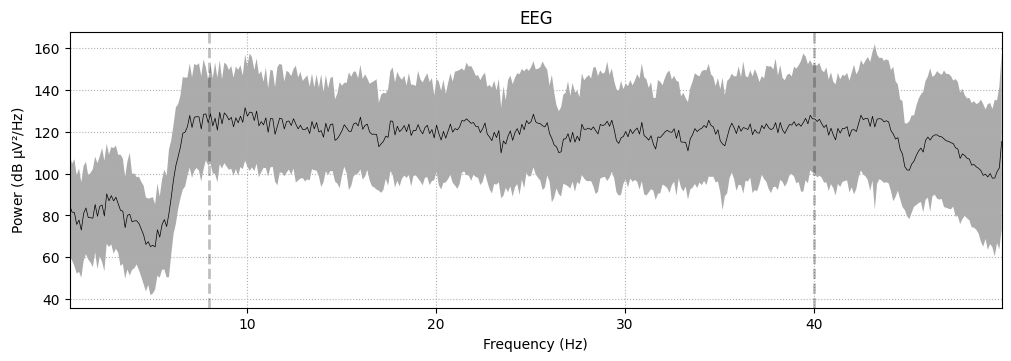

In [126]:
plot_psd_from_df(
    df=interpolated_df,
    sfreq=250,
    low_freq=8,
    high_freq=40,
    fmin=0.5,
    fmax=50,
)